# Hilbert-Schmidt Independence Criterion (HSIC)

In [1]:
import sys
sys.path.append("../../../")

import objax
import jax
import jax.numpy as np

from jaxkern.kernels.stationary import RBF
from jaxkern.kernels.linear import Linear
from jaxkern.similarity.hsic import HSIC, CKA, HSICRBF, CKARBF
from jaxkern.kernels.sigma import estimate_sigma_median

from jaxkern.data.similarity import generate_data

# 
import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

/Users/eman/miniconda3/envs/jaxkern/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


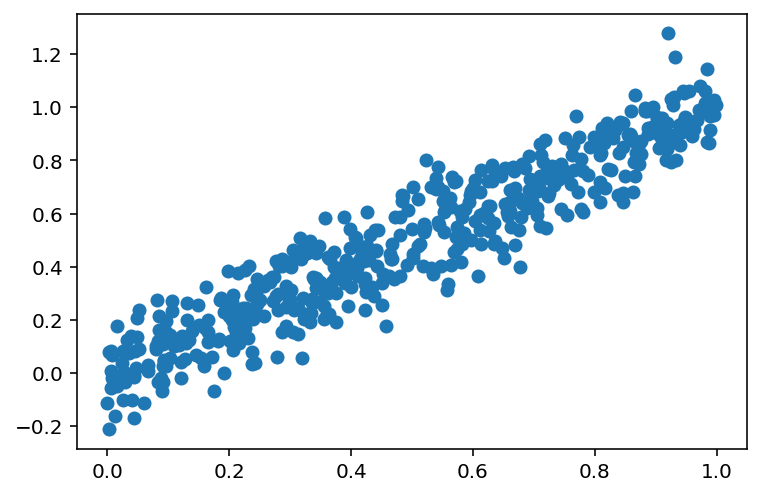

In [2]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
noise_y = 0.1

X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## HSIC - From Scratch

#### 1. Calculate Kernel Matrices

In [3]:
from jaxkern.kernels.linear import Linear

# initialize kernel
lin_kern = Linear()

# calculate kernel matrices
K_x = lin_kern(X, X)
K_y = lin_kern(Y, Y)

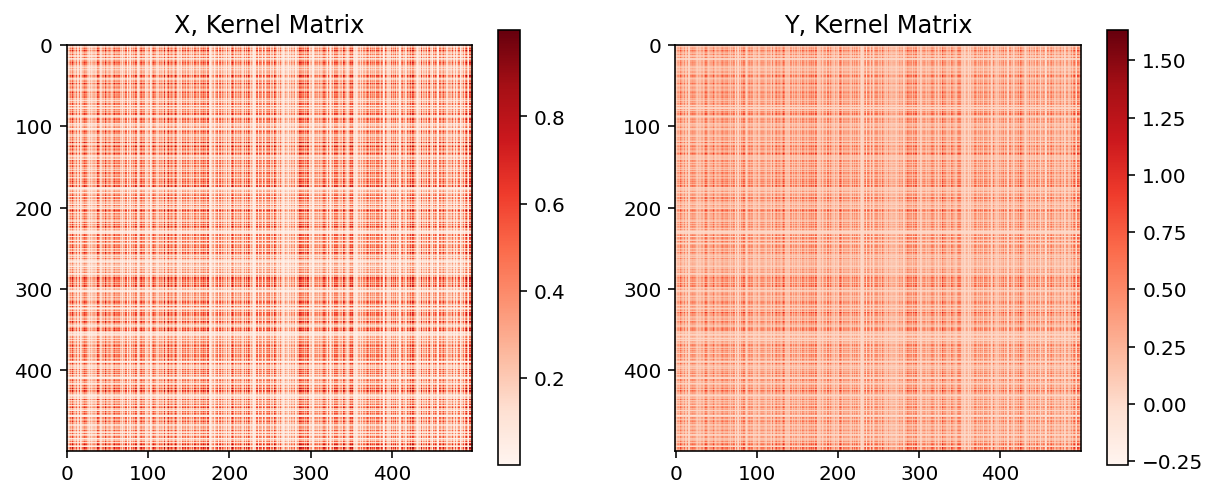

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_x, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(K_y, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

#### 2. Center Kernel Matices

Kernel Centerer:
$$\text{H}=I- \left( \frac{1}{N}\right)\mathbb{1}$$

In [5]:
from jaxkern.kernels.utils import centering

# center matrix
K_xc = centering(K_x)
K_yc = centering(K_y)

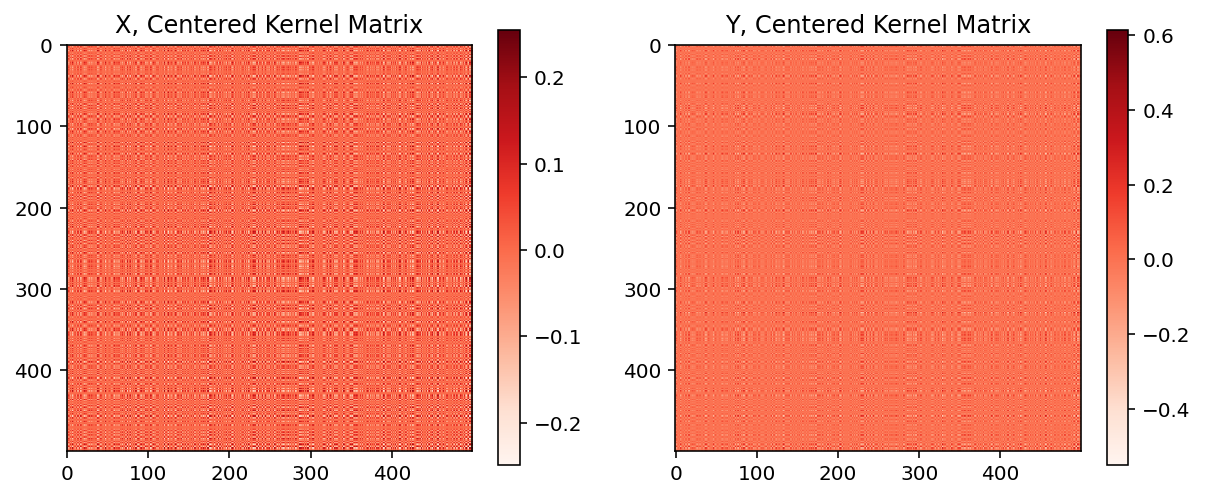

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_xc, cmap='Reds')
ax[0].set_title("X, Centered Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(K_yc, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Centered Kernel Matrix")
plt.show()

#### 3. Summarize: HSIC Norm

Here we implement the HSIC norm which is a way to summarize the information with the matrices.

$$
\text{HSIC}(\mathbf{X}, \mathbf{Y}) = \langle \tilde{K}_x, \tilde{K}_y \rangle_{\text{HS}}
$$

In [7]:
hsic_value = np.sum(K_xc * K_yc)

# scaling term

print(f"HSIC: {hsic_value:.4f}")

HSIC: 1710.8794


#### 4. Bias Terms

In [8]:
bias = 1 / (K_yc.shape[0]**2)

hsic_val_s = bias * hsic_value

print(f"HSIC: {hsic_val_s:.4f}")

HSIC: 0.0068


#### 5. Normalize

So it's very difficult to interpret HSIC in terms of similarity. It's similar to the covariance matrix, we need to normalize by the sizes of the individual matrices.

In [9]:
nhsic_value = np.sum(K_xc * K_yc) / np.linalg.norm(K_xc) / np.linalg.norm(K_yc)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.8908


### Linear Kernel

In [10]:
kernel = Linear()

hsic_clf = HSIC(kernel, kernel, bias=True)

hsic_val = hsic_clf(X, Y)


print(f"HSIC: {hsic_val:.4f}")
# calculate hsic value

HSIC: 0.0068


### RBF Kernel

In [11]:
# estimate sigma
σ_x = estimate_sigma_median(X, X)
σ_y = estimate_sigma_median(Y, Y)

print(f"σ_x: {σ_x:.4f}" )
print(f"σ_y: {σ_y:.4f}" )

# calculate kernel matrices
kernel_X = RBF(variance=1.0, length_scale=σ_x)
kernel_Y = RBF(variance=1.0, length_scale=σ_y)

σ_x: 0.0838
σ_y: 0.0945


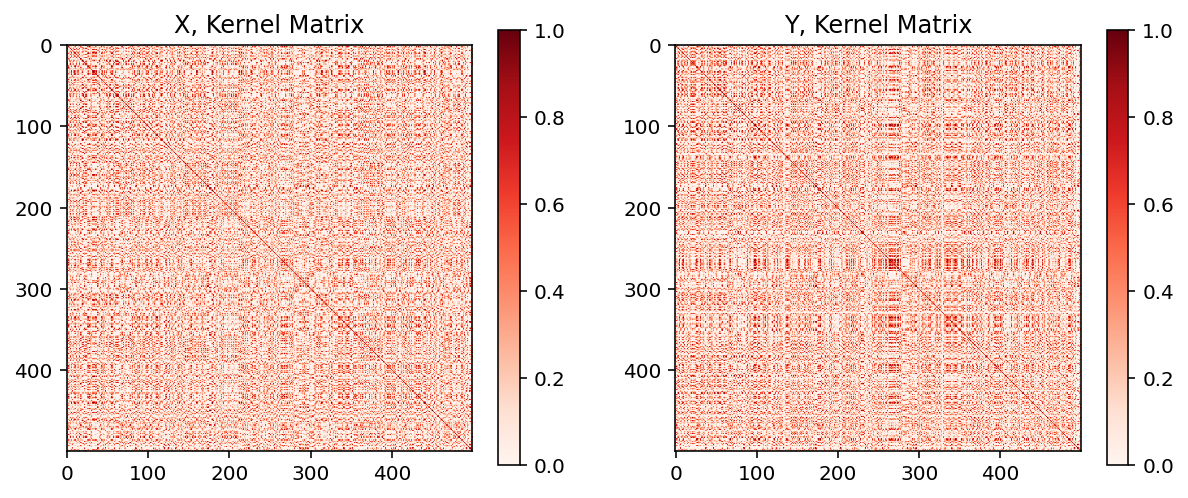

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(kernel_X(X,X), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(kernel_Y(Y, Y), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

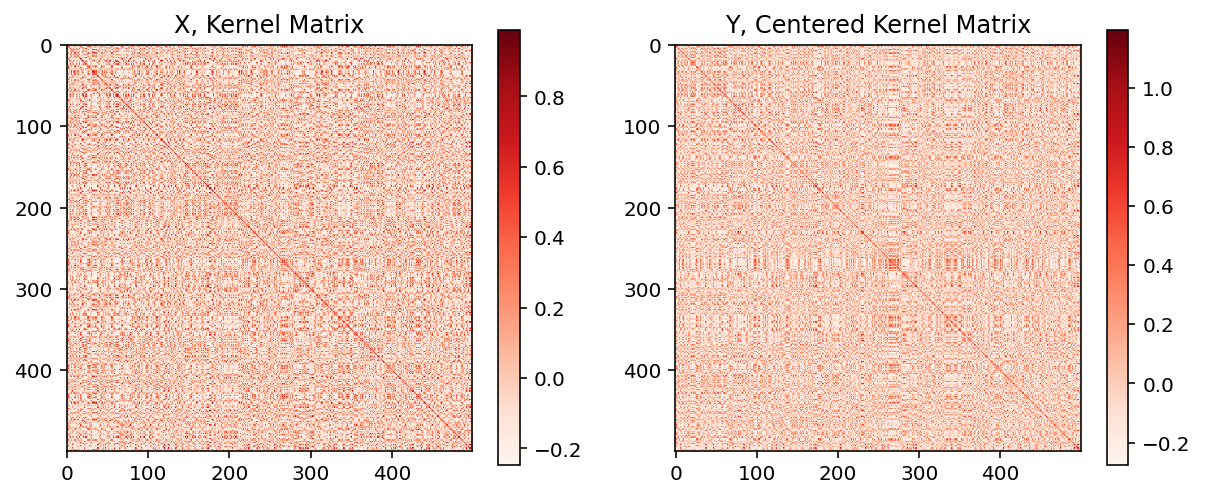

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(centering(kernel_X(X,X)), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(centering(kernel_Y(Y,Y)), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Centered Kernel Matrix")
plt.show()

In [14]:
# initialize HSIC model
hsic_clf = CKA(kernel_X, kernel_Y, bias=True)

# calculate HSIC
hsic_val = hsic_clf(X, Y)
print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.5489


#### Convenience Function

Let's be honest, most people are going to use the RBF kernel. It's universal, quick n dirty, and quite simple to interpretate. So I made a convenience function to help people deal with it.

In [15]:
sigma_f = estimate_sigma_median

nhsic_clf = CKARBF(sigma_f, sigma_f)

nhsic_value = nhsic_clf(X, Y)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.5489


## Other Datasets

### Non-Linear

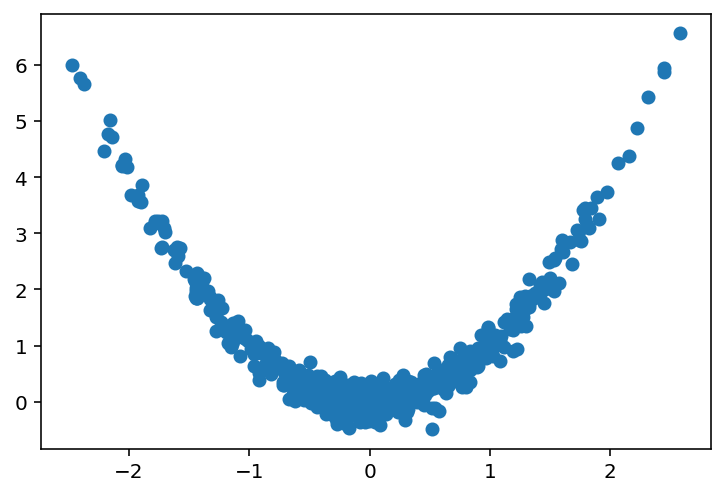

In [16]:
X = onp.random.randn(n_samples, 1)
Y = X**2 + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

plt.scatter(X, Y)

#### Linear Kernel

In [17]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0018


#### RBF Kernel

In [18]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.4132


### Periodic

In [19]:
X = np.abs(2 * onp.random.randn(n_samples, 1))
Y = np.sin(X) + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

#### Linear Kernel

In [20]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.2029


#### RBF Kernel

In [21]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.1840


### Circle

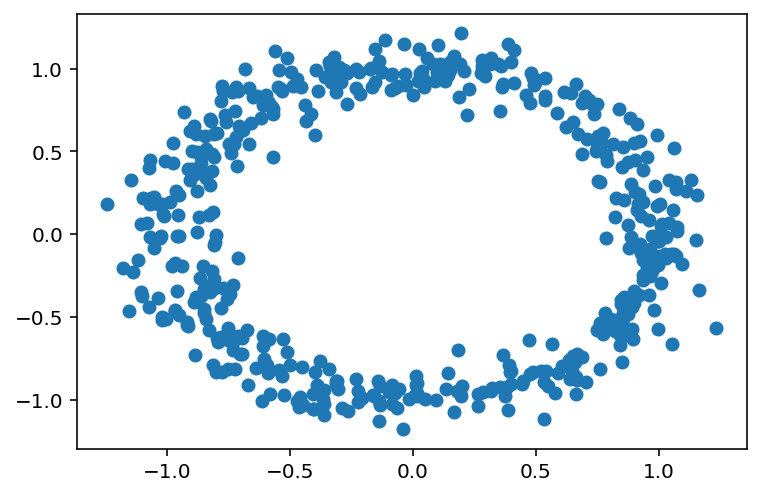

In [22]:
X, Y = generate_data(n_samples, "circle", noise_y=0.1, noise_x=0.1)

plt.scatter(X, Y)

#### Linear Kernel

In [23]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0006


#### RBF Kernel

In [24]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.1128


### Random

In [25]:
X, Y = generate_data(n_samples, "random", noise_y=noise_y)

#### Linear Kernel

In [26]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0029


#### RBF Kernel

In [27]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.0167


## MMD Equivalent

In [28]:
X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

In [29]:
# linear kernel
K_x = lin_kern(X, X)
K_y = lin_kern(Y, Y)

# center matrices
K_xc = centering(K_x)
K_yc = centering(K_y)

In [30]:
# get the expectrations
A = np.mean(K_xc * K_yc)
B = np.mean(np.mean(K_xc, axis=0) * np.mean(K_yc, axis=0))
C = np.mean(K_xc) * np.mean(K_yc)

In [31]:
print(f"A: {A:.2e}")
print(f"B: {B:.2e}")
print(f"C: {C:.2e}")

A: 6.84e-03
B: -1.03e-16
C: -3.26e-19


In [32]:
# calculate MMD
mmd_value = A - 2 * B + C

print(f"MMD: {mmd_value:.4f}")

MMD: 0.0068
